In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sales-forecasting/train.csv


In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import lightgbm as lgb
from xgboost import XGBRegressor

In [4]:
path='/kaggle/input/sales-forecasting/train.csv'
df= pd.read_csv(path)
df

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9795,9796,CA-2017-125920,21/05/2017,28/05/2017,Standard Class,SH-19975,Sally Hughsby,Corporate,United States,Chicago,Illinois,60610.0,Central,OFF-BI-10003429,Office Supplies,Binders,"Cardinal HOLDit! Binder Insert Strips,Extra St...",3.7980
9796,9797,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,OFF-AR-10001374,Office Supplies,Art,"BIC Brite Liner Highlighters, Chisel Tip",10.3680
9797,9798,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10004977,Technology,Phones,GE 30524EE4,235.1880
9798,9799,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10000912,Technology,Phones,Anker 24W Portable Micro USB Car Charger,26.3760


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [6]:
df.isnull().sum()

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

In [7]:
df.dropna(inplace=True)

In [9]:
df["Order Date"] = pd.to_datetime(df["Order Date"], format="%d/%m/%Y")
df["Ship Date"] = pd.to_datetime(df["Ship Date"], format="%d/%m/%Y")
df["Order Year"] = df["Order Date"].dt.year
df["Order Month"] = df["Order Date"].dt.month
df["Ship Year"] = df["Ship Date"].dt.year
df["Ship Month"] = df["Ship Date"].dt.month

In [10]:
df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Order Year       0
Order Month      0
Ship Year        0
Ship Month       0
dtype: int64

In [11]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Region,Product ID,Category,Sub-Category,Product Name,Sales,Order Year,Order Month,Ship Year,Ship Month
0,1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2017,11,2017,11
1,2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,2017,11,2017,11
2,3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2017,6,2017,6
3,4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,2016,10,2016,10
4,5,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2016,10,2016,10


In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9789 entries, 0 to 9799
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9789 non-null   int64         
 1   Order ID       9789 non-null   object        
 2   Order Date     9789 non-null   datetime64[ns]
 3   Ship Date      9789 non-null   datetime64[ns]
 4   Ship Mode      9789 non-null   object        
 5   Customer ID    9789 non-null   object        
 6   Customer Name  9789 non-null   object        
 7   Segment        9789 non-null   object        
 8   Country        9789 non-null   object        
 9   City           9789 non-null   object        
 10  State          9789 non-null   object        
 11  Postal Code    9789 non-null   float64       
 12  Region         9789 non-null   object        
 13  Product ID     9789 non-null   object        
 14  Category       9789 non-null   object        
 15  Sub-Category   9789 non-nu

In [137]:
df['Sales'].describe()

count     9789.000000
mean       230.116193
std        625.302079
min          0.444000
25%         17.248000
50%         54.384000
75%        210.392000
max      22638.480000
Name: Sales, dtype: float64

In [140]:
df.groupby(["Ship Mode"])[["Sales"]].sum().sort_values("Sales")

,Sales
Ship Mode,
Same Day,1.252190e+05
First Class,3.455723e+05
Second Class,4.491990e+05
Standard Class,1.332617e+06


<Axes: xlabel='Order Year'>

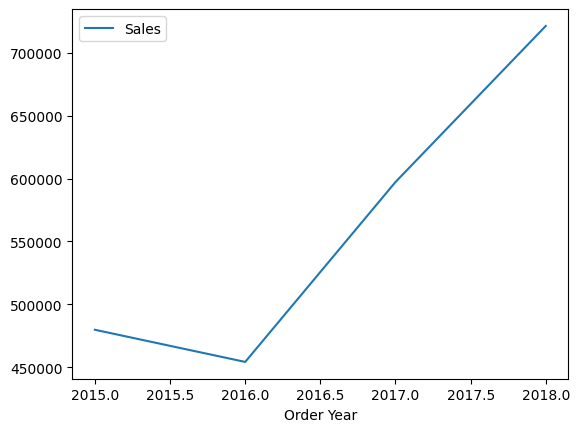

In [141]:
df.groupby(["Order Year"])[["Sales"]].sum().sort_values("Order Year").plot()

<Axes: ylabel='count'>

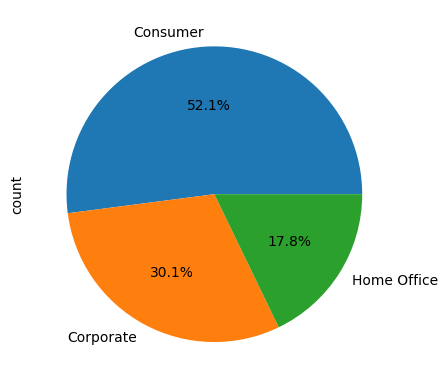

In [142]:
df["Segment"].value_counts().plot(kind = "pie" , autopct = "%1.1f%%")

<Axes: ylabel='count'>

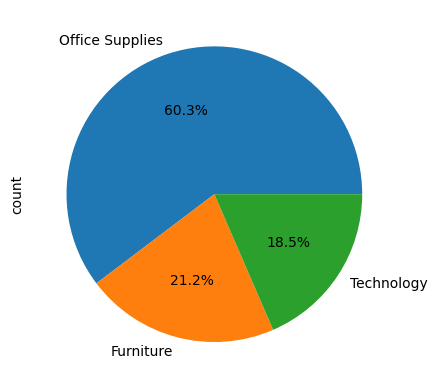

In [17]:
df["Category"].value_counts().plot(kind = "pie" , autopct = "%1.1f%%")

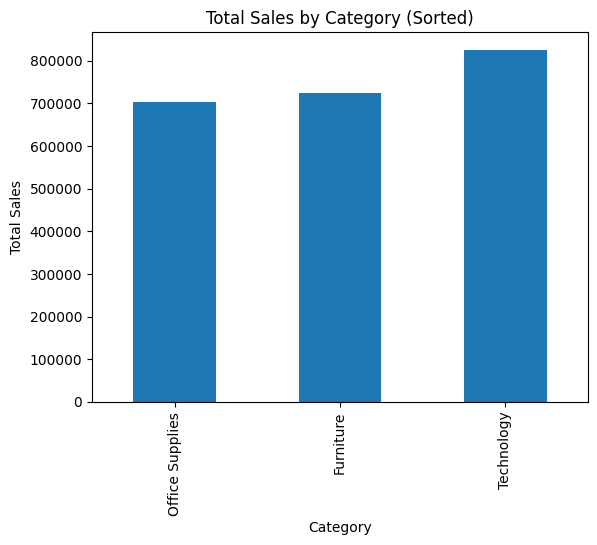

In [18]:
sales_by_category = df.groupby(["Category"])[["Sales"]].sum().sort_values("Sales")
sales_by_category.plot(kind='bar', legend=False)
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.title('Total Sales by Category (Sorted)')
plt.show()

Text(0.5, 1.0, 'top10 states')

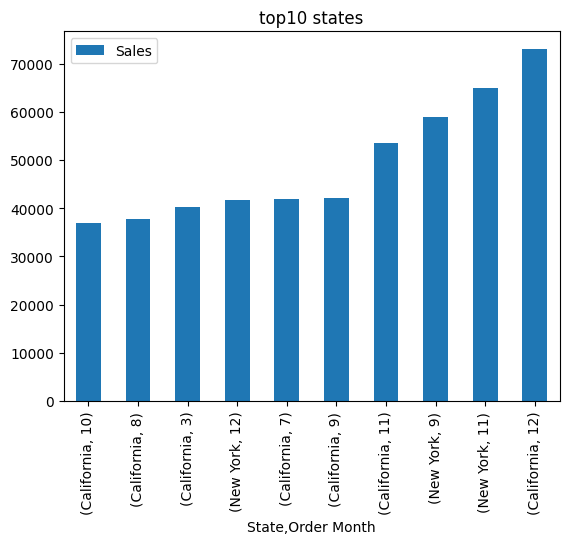

In [19]:
top_10 = df.groupby(["State" , "Order Month"])[["Sales"]].sum().sort_values("Sales").tail(10)
top_10.plot(kind = "bar")
plt.title("top10 states")

<Axes: xlabel='Category', ylabel='Sales'>

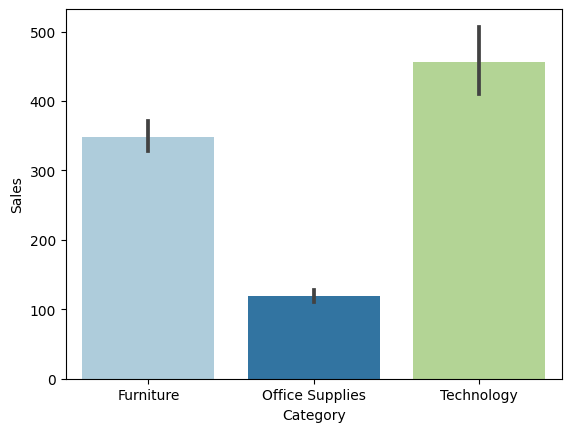

In [20]:
sns.barplot(data=df , x= "Category", y= "Sales" , palette = "Paired")

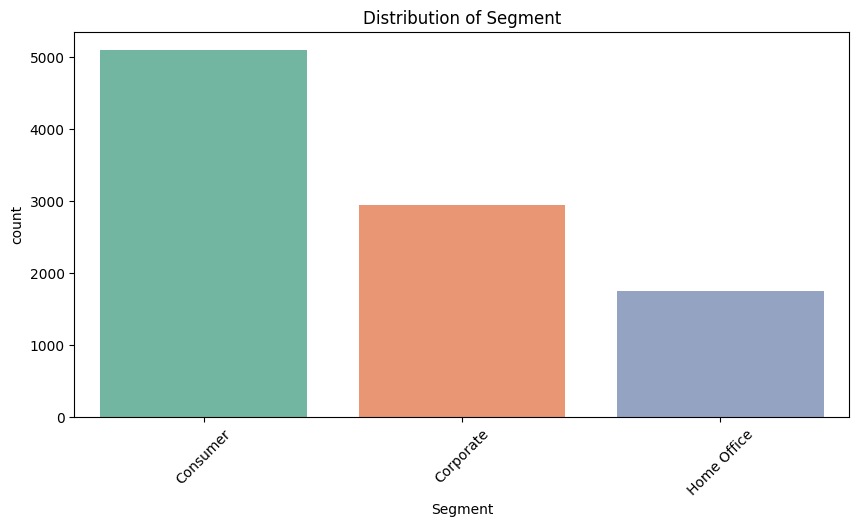

In [21]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Segment", palette="Set2")
plt.xticks(rotation=45)
plt.title("Distribution of Segment")
plt.show()

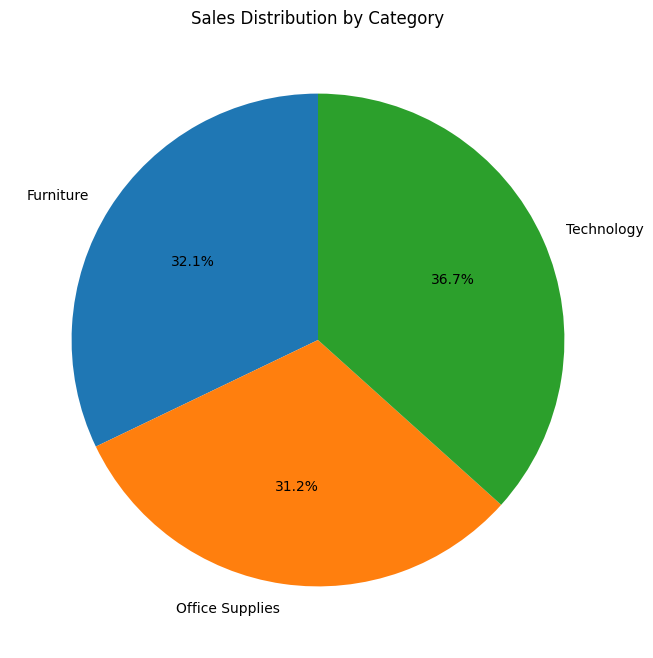

In [22]:
sales_by_category = df.groupby("Category")["Sales"].sum()

plt.figure(figsize=(8, 8))
plt.pie(sales_by_category, labels=sales_by_category.index, autopct='%1.1f%%', startangle=90)
plt.title("Sales Distribution by Category")
plt.show()

<Axes: xlabel='Order Year', ylabel='Sales'>

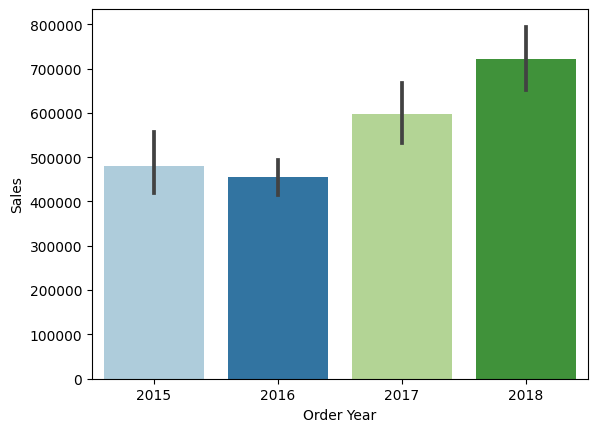

In [23]:
sns.barplot(data=df, x='Order Year', y='Sales', estimator=sum, palette='Paired')# Rotate x-axis labels for better readabilityplt.xticks(rotation=45)# Adding labels and titleplt.xlabel('Order Year')plt.ylabel('Total Sales')plt.title('Total Sales by Order Year')# Display the plotplt.show()

<Axes: xlabel='Order Month', ylabel='Sales'>

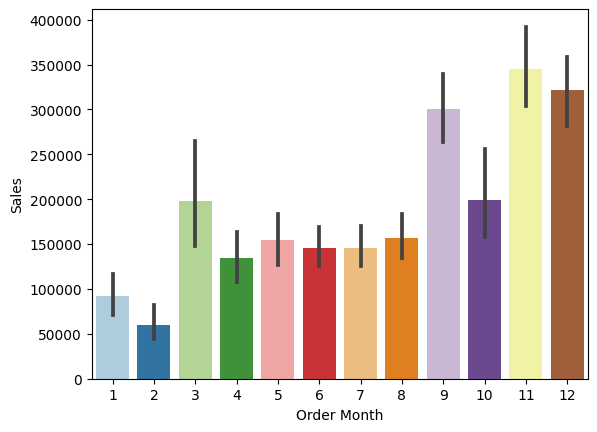

In [24]:
sns.barplot(data=df, x='Order Month', y='Sales', estimator=sum, palette='Paired')# Rotate x-axis labels for better readabilityplt.xticks(rotation=45)# Adding labels and titleplt.xlabel('Order Month')plt.ylabel('Total Sales')plt.title('Total Sales by Order Year')# Display the plotplt.show()

**LinearRegression**

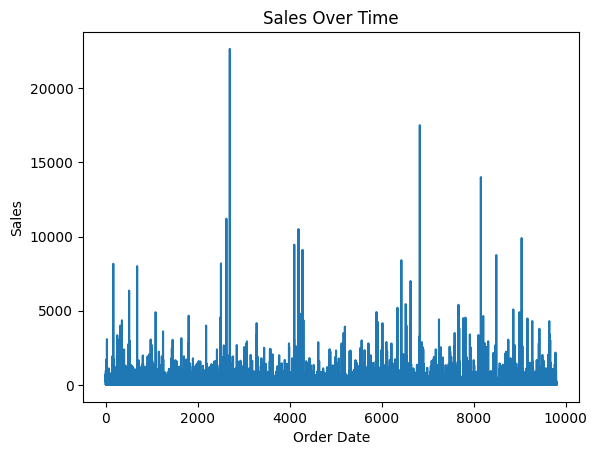

In [216]:
df['Sales'].plot()
plt.title("Sales Over Time")
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.show()

In [178]:
X=df[['Order Year','Order Month']]
y=df['Sales']

In [179]:

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=42)

# Initialize Linear Regression model
regressor = LinearRegression()

# Train the model
regressor.fit(x_train, y_train)

# Predict on test data
preds = regressor.predict(x_test)

# Calculate evaluation metrics
rmse_rf = sqrt(mean_squared_error(y_test, preds))
mae_rf = mean_absolute_error(y_test, preds)
r2_rf = r2_score(y_test, preds)

# Print evaluation metrics
print("Root Mean Squared Error for Linear Regression:", rmse_rf)
print("Mean Absolute Error for Linear Regression:", mae_rf)
print("R-squared for Linear Regression:", r2_rf)

Root Mean Squared Error for Linear Regression: 623.6946945517109
Mean Absolute Error for Linear Regression: 273.04964940102633
R-squared for Linear Regression: -0.0007005959215469204


**RandomForestRegressor**x_testXGBRegressor

In [182]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(x_train, y_train)

# Predict on test data
preds = rf_model.predict(x_test)

# Calculate evaluation metrics
rmse_rf = sqrt(mean_squared_error(y_test, preds))
mae_rf = mean_absolute_error(y_test, preds)
r2_rf = r2_score(y_test, preds)

# Print evaluation metrics
print("Root Mean Squared Error for Random Forest:", rmse_rf)
print("Mean Absolute Error for Random Forest:", mae_rf)
print("R-squared for Random Forest:", r2_rf)

Root Mean Squared Error for Random Forest: 626.2235407827346
Mean Absolute Error for Random Forest: 274.90085002190693
R-squared for Random Forest: -0.008831972706053737


**LightGBM**

In [183]:
# Prepare data
numeric_columns = df.select_dtypes(include=['number']).columns
xgb_sales = pd.DataFrame(df.groupby(by=['Order Date'])[numeric_columns].sum())

x = xgb_sales.drop('Sales', axis=1)
y = xgb_sales['Sales']

# Replace whitespace in feature names
x.columns = x.columns.str.replace(' ', '_')

# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=42)

# Create the LightGBM data containers
train_data = lgb.Dataset(x_train, label=y_train)
test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

# Define parameters
params = {
    'learning_rate': 0.03,
    'max_depth': 6,  # Increased max depth
    'num_leaves': 31,
    'objective': 'regression',
    'metric': 'rmse',
    'force_col_wise': True  # Force column-wise multi-threading
}

# Train the model
model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

# Predict
preds = model.predict(x_test, num_iteration=model.best_iteration)

# Calculate metrics
rmse_lgb = sqrt(mean_squared_error(y_test, preds))
mae_lgb = mean_absolute_error(y_test, preds)
r2_lgb = r2_score(y_test, preds)
model_score = r2_lgb  # Using R-squared as the model score

print("Root Mean Squared Error for LightGBM:", rmse_lgb)
print("Mean Absolute Error for LightGBM:", mae_lgb)
print("R-squared for LightGBM:", r2_lgb)
print("Model Score for LightGBM:", model_score)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 911
[LightGBM] [Info] Number of data points in the train set: 860, number of used features: 7
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 1899.165487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

**XGBRegressort**

In [184]:
numeric_columns = df.select_dtypes(include=['number']).columns
xgb_sales = pd.DataFrame(df.groupby(by=['Order Date'])[numeric_columns].sum())

x = xgb_sales.drop('Sales', axis=1)
y = xgb_sales['Sales']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.3, random_state=42)

model = XGBRegressor(learning_rate=0.03, max_depth=1,)
model.fit(x_train, y_train)

preds = model.predict(x_test)
rmse_xgb = sqrt(mean_squared_error(y_test, preds))
model_score = model.score(x_test, y_test)

print("Root Mean Squared Error for XGBoost:", rmse_xgb)
print("Model Score:", model_score)

Root Mean Squared Error for XGBoost: 1655.8959251381773
Model Score: 0.3748410606841752


In [200]:
X = df[['Order Year','Order Month', 'Sales']]

In [201]:
kmeans = []
for i in range(1,9):
  model = KMeans(n_clusters=i)
  model.fit(X)
  kmeans.append(model.inertia_)
kmeans

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

[3827251865.982505,
 1974577457.632773,
 998499809.2525662,
 602207099.943185,
 406568400.1176128,
 258014676.50851807,
 183355116.60428956,
 136627717.9707435]

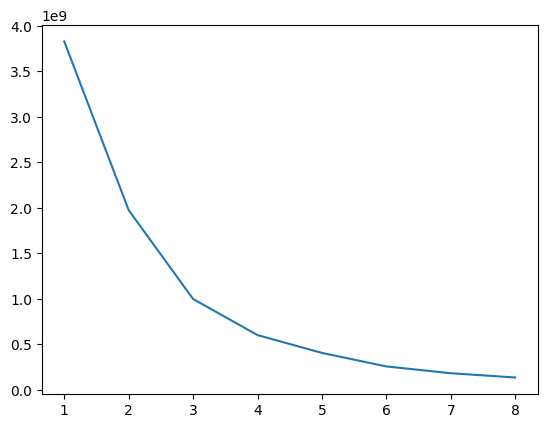

In [202]:
n = list(range(1,9))
plt.plot(n,kmeans)
plt.show()

In [203]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2)

In [204]:
df['Cluster'] = kmeans.labels_  # Add cluster labels to the DataFrame

# Now, you can use df['Cluster'] for silhouette scoring
Cluster = df['Cluster']

In [205]:
df['Cluster'] = kmeans.fit_predict(X)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [210]:
 # Assuming df['Cluster'] contains the labels
silhouette_avg = silhouette_score(X, Cluster)
print(f'Silhouette Score: {silhouette_avg * 100:.2f}%')

Silhouette Score: 92.22%
